**import packages**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import warnings 
warnings.filterwarnings("ignore")
import time

# DATA PREPARATION
## Load the training data and test data

In [2]:
column_name = ['engine_id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
               's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
               's15', 's16', 's17', 's18', 's19', 's20', 's21']
train_FD001 = pd.read_table("./CMAPSSData/train_FD001.txt", header=None, delim_whitespace=True)
train_FD001.columns = column_name
# Test 文件中的cycle数 并不是到死的
test_FD001 = pd.read_table("./CMAPSSData/test_FD001.txt", header=None, delim_whitespace=True)
test_FD001.columns = column_name

# load RUL data 真正的最后循环数存放在这里
RUL_FD001 = pd.read_table("./CMAPSSData/RUL_FD001.txt", header=None, delim_whitespace=True)

In [3]:
train_FD001.head()

,engine_id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


## standard normalization
<span class="mark">train 和 test 集一定都要 正则化，方法就是减去平均值除以方差。
需要注意的是，test集上，正则化用的是training数据的平均值和方差。只能用训练数据集上的信息，test集上的一切信息都不能用。</span>

In [4]:
#### standard normalization ####

# Training 因为前两列是没有用的 engine_id cycle
mean = train_FD001.iloc[:, 2:].mean()
std = train_FD001.iloc[:, 2:].std()
std.replace(0, 1, inplace=True)
train_FD001.iloc[:, 2:] = (train_FD001.iloc[:, 2:] - mean) / std

# Testing
test_FD001.iloc[:, 2:] = (test_FD001.iloc[:, 2:] - mean) / std

## Compute the RUL

'''
    Piecewise linear function with zero gradient and unit gradient
    
            ^
            |
    MAXLIFE |-----------
            |            \
            |             \
            |              \
            |               \
            |                \
            |----------------------->
    '''
    因为从下图的可视化可以看出，所有的传感器值的变化并不是一个逐渐降低的过程。而是先保持平稳，再出现逐渐变化的趋势。
    也就是说，在刚开始机器的状态并没有开始下滑。而是到一个临界点的时候，才开始下滑。
    那么临界点之前的数据，如果强行默认下滑，可能不好学习。
    临街点的值是通过可视化，凭借经验定义的，大部分都是在倒数120周期的时候开始变化。
<span class="mark">其实可以通过wavelet transformation 降噪，得出变化点的开头，不同数据集。定义不同的临界点！</span>

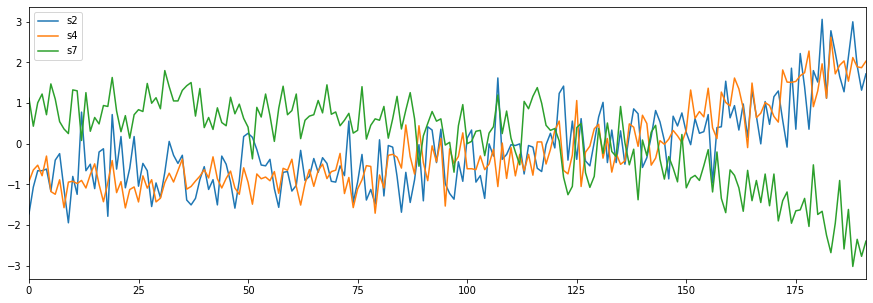

In [5]:
train_FD001[train_FD001["engine_id"]==1][["s2","s4","s7"]].plot(figsize=(15,5));

### Training

In [6]:
id='engine_id'
# 这个是自己定义的， 拐点在120 ，  120之前视为一样
MAXLIFE = 125
rul = [] # 会逐渐装满所有id的RUL
for _id in set(train_FD001[id]):
    trainFD001_of_one_id =  train_FD001[train_FD001[id] == _id]
    cycle_list = trainFD001_of_one_id['cycle'].tolist()
    # 因为这里是run to end ,所以最大cycle数是确定的
    max_cycle = max(cycle_list)
    # 计算出临界点的位置，没到达临界点的时候，全部保存MAXLIFE，到达临界点的时候，逐点下降！
    knee_point = max_cycle - MAXLIFE
    kink_RUL = []
    for i in range(0, len(cycle_list)):
        # 
        if i < knee_point:
            kink_RUL.append(MAXLIFE)
        else:
            tmp = kink_RUL[i - 1] - 1
            kink_RUL.append(tmp)
    # 每跑完一个id就添加到最后总的rul列表中
    rul.extend(kink_RUL)

train_FD001["RUL"] = rul

# training_engine_id = train_FD001['engine_id']
# train_FD001 = train_FD001.drop('engine_id', 1)
# train_FD001 = train_FD001.drop('cycle', 1)

### Testing
TEST数据集和训练数据集是不一样的，RUL是定义好了的。已经读在了RUL_FD001 dataframe里面

In [7]:
id='engine_id'
rul = []
for _id in set(test_FD001[id]):
    # 真实的RUL， 也就是测试数据最后一个周期所对应的RUL
    true_rul = int(RUL_FD001.iloc[_id - 1])
    testFD001_of_one_id =  test_FD001[test_FD001[id] == _id]
    cycle_list = testFD001_of_one_id['cycle'].tolist()
    # 那么总的生命周期数=训练集的已有周期数+最后剩下的周期数
    max_cycle = max(cycle_list) + true_rul
    knee_point = max_cycle - MAXLIFE
    kink_RUL = []
    for i in range(0, len(cycle_list)):
        if i < knee_point:
            kink_RUL.append(MAXLIFE)
        else:
            tmp = kink_RUL[i - 1] - 1
            kink_RUL.append(tmp)    

    rul.extend(kink_RUL)

test_FD001["RUL"] = rul

    训练数据的格式应该是[batch, timesteps, windowsize, numberofsensor] (这里没有考虑channel的维度）
    如果timesteps设置为10，窗口大小设置为24
    那么一个训练集最短至少要有33
    测试集的输入尺寸除了batch,都要保持和训练集的一致
<span class="mark">所以timesteps和窗口大小不能随意定</span>

In [8]:
min_shape = np.min([i[0] for i in train_FD001.groupby("engine_id").apply(np.shape).values])
print("训练集中最小的长度是：",min_shape)

训练集中最小的长度是： 128


In [9]:
min_shape = np.min([i[0] for i in test_FD001.groupby("engine_id").apply(np.shape).values])
print("测试集中最小的长度是：",min_shape)

测试集中最小的长度是： 31


In [10]:
# test_FD001 = test_FD001.drop('engine_id', 1)
# test_FD001 = test_FD001.drop('cycle', 1)
# test_values = test_FD001.values

    这时候 train_FD001 和 test_FD001结构是一样的，第一列是id，中间24个传感器数据，最后一列是 rul

In [11]:
train_FD001[train_FD001["engine_id"]==1].head()

,engine_id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.315972,-1.372920,0.0,0.999976,-1.721684,-0.134252,-0.925914,0.999976,...,-1.058865,-0.269065,-0.603801,0.999976,-0.781691,0.0,0.0,1.348460,1.194398,125
1,1,2,0.872701,-1.031695,0.0,0.999976,-1.061754,0.211523,-0.643710,0.999976,...,-0.363637,-0.642829,-0.275845,0.999976,-0.781691,0.0,0.0,1.016503,1.236892,125
2,1,3,-1.961827,1.015652,0.0,0.999976,-0.661797,-0.413156,-0.525940,0.999976,...,-0.919819,-0.551616,-0.649128,0.999976,-2.073044,0.0,0.0,0.739873,0.503411,125
3,1,4,0.324083,-0.008022,0.0,0.999976,-0.661797,-1.261284,-0.784812,0.999976,...,-0.224592,-0.520163,-1.971617,0.999976,-0.781691,0.0,0.0,0.352590,0.777773,125
4,1,5,-0.864590,-0.690471,0.0,0.999976,-0.621801,-1.251498,-0.301511,0.999976,...,-0.780774,-0.521736,-0.339837,0.999976,-0.136014,0.0,0.0,0.463242,1.059526,125


In [12]:
train_FD001 = train_FD001.drop(['s1','setting1','setting2','setting3','s5','s6','s10','s16','s18','s19'],axis = 1)

In [13]:
train_FD001

,engine_id,cycle,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,RUL
0,1,1,-1.721684,-0.134252,-0.925914,1.121113,-0.516326,-0.862792,-0.266460,0.334254,-1.058865,-0.269065,-0.603801,-0.781691,1.348460,1.194398,125
1,1,2,-1.061754,0.211523,-0.643710,0.431920,-0.798074,-0.958794,-0.191578,1.174871,-0.363637,-0.642829,-0.275845,-0.781691,1.016503,1.236892,125
2,1,3,-0.661797,-0.413156,-0.525940,1.008131,-0.234578,-0.557126,-1.015279,1.364688,-0.919819,-0.551616,-0.649128,-2.073044,0.739873,0.503411,125
3,1,4,-0.661797,-1.261284,-0.784812,1.222798,0.188044,-0.713808,-1.539452,1.961255,-0.224592,-0.520163,-1.971617,-0.781691,0.352590,0.777773,125
4,1,5,-0.621801,-1.251498,-0.301511,0.714376,-0.516326,-0.457048,-0.977838,1.052846,-0.780774,-0.521736,-0.339837,-0.136014,0.463242,1.059526,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,1.617961,1.216229,2.188322,-2.189276,1.315035,0.012546,1.979996,-2.607906,2.278227,-0.322534,1.425260,2.446692,-1.805129,-2.921042,4
20627,100,197,1.717950,2.279651,2.738285,-2.833277,1.878530,-0.006020,1.867673,-2.350298,1.722045,-0.380198,1.913194,1.155339,-2.856326,-1.203735,3
20628,100,198,1.477975,1.946924,2.138325,-2.742891,2.019404,0.029754,2.054877,-1.902872,2.000136,-0.141680,3.265013,3.092369,-2.081760,-3.292402,2
20629,100,199,1.098016,2.403608,1.955004,-3.036645,2.160278,0.383875,3.178105,-2.363856,1.861090,-0.233942,2.579771,1.155339,-2.911652,-2.085021,1


In [14]:
test_FD001 = test_FD001.drop(['s1','setting1','setting2','setting3','s5','s6','s10','s16','s18','s19'],axis = 1)

### Plot a figure

training (20631, 14) (20631,)
testing (13096, 14) (13096,)


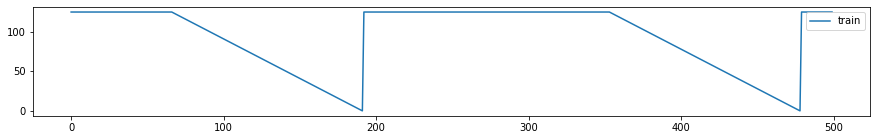

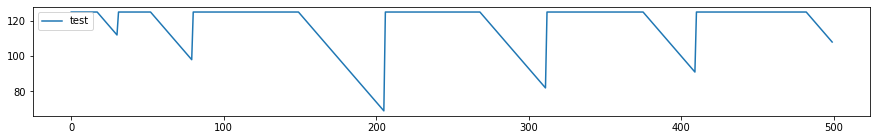

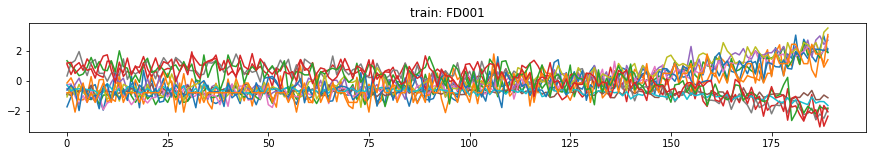

In [15]:
training_data = train_FD001.values
testing_data = test_FD001.values

x_train = training_data[:, 2:-1]
y_train = training_data[:, -1]
print("training", x_train.shape, y_train.shape)

x_test = testing_data[:, 2:-1]
y_test = testing_data[:, -1]
print("testing", x_test.shape, y_test.shape)
# 训练数据集 前面500个数据点所对应的rul 由图中可以看出  都是到零的了
plt.figure(figsize=(15,2))
plt.plot(y_train[:500], label="train")
plt.legend()
plt.figure(figsize=(15,2))
# 测试数据中前500个数据点对应的tul  可以看到结尾数据的rul 都不是中间
plt.plot(y_test[:500], label="test")
plt.legend()
plt.figure(figsize=(15,2))
plt.plot(x_train[:190])
plt.title("train: FD00" + str(1))
# 训练数据第一个id的 24个senor的值 可以通过在x轴坐标100的位置 序列的一些 趋势

plt.show()

In [16]:
test_FD001.head()

,engine_id,cycle,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,RUL
0,1,1,0.678061,-0.853530,-1.191451,0.601394,-0.798074,-0.682562,-1.277365,0.415604,-0.919819,-0.954212,-0.985083,-0.781691,0.241938,0.774078,125
1,1,2,-1.941660,-0.338129,-1.501430,1.674728,-1.220695,-0.490106,-0.154137,1.012171,-0.502683,-0.216643,-1.648994,-0.136014,1.127156,0.941282,125
2,1,3,-0.441820,-0.584412,-0.843697,0.838657,-0.657200,-0.375084,-0.154137,0.754562,-0.919819,-0.715695,0.052111,-0.136014,1.459112,1.172227,125
3,1,4,-0.481816,-1.044359,-0.279290,0.793464,-0.938948,-0.903548,-0.977838,-0.045380,-0.641728,-0.568915,-1.345035,-1.427367,1.016503,0.775926,125
4,1,5,-0.341831,-0.543637,-0.779257,0.895148,-1.220695,-0.937058,-0.865515,0.998612,-0.919819,-0.745051,-1.041076,-2.073044,0.961177,1.138971,125


# Feature extention

## Difference with previous row

In [17]:
#diff_periods=40
#s2_diff = pd.diff()

# Convolutional NN

In [18]:
def batch_generator(training_data, sequence_length=15, window_size = 15):
    """
    Generator function for creating random batches of training-data for many to many models
    """
    engine_ids = list(training_data["engine_id"].unique())
    temp = training_data.copy()
    # 把 每一段后一截给截掉，获取能够跑的index
    for id_ in engine_ids:
        indexes = temp[temp["engine_id"] == id_].index
        traj_data = temp.loc[indexes]
        # cutoff_cycle 记录下这以后的index就不满足 序列大小的需求的
        cutoff_cycle = max(traj_data['cycle']) - sequence_length - window_size + 1
        
        if cutoff_cycle<0:
            # 也就是步长和窗口大小已经大于了该机器的已有周期数，全部都得扔掉
            drop_range = indexes
            print("有一些数据直接就被抛弃了，请合理设置窗口大小和时间长度")
        else:
            cutoff_cycle_index = traj_data['cycle'][traj_data['cycle'] == cutoff_cycle+2].index
            drop_range = list(range(cutoff_cycle_index[0], indexes[-1] + 1))
            
        temp.drop(drop_range, inplace=True)
    indexes = temp.index
    del temp
    

    x_shape = (len(indexes), sequence_length, window_size, 14)
    x_batch = np.zeros(shape=x_shape, dtype=np.float32)
    y_shape = (len(indexes), sequence_length)
    y_batch = np.zeros(shape=y_shape, dtype=np.float32)
    
    # 第一个数据集
    alt_index = indexes[0]
    for batch_index, index in enumerate(indexes):
        # 因为对齐的原因，都减去了1
        y_batch[batch_index] = training_data.iloc[index+window_size-1:index+window_size-1+sequence_length,-1].values
        
        # 本来应该下面这个 for 循环的，但是考虑到循环的嵌套，跑太久了，而且窗口序列之间又有重复，那么减少循环的次数
        # for seq in range(sequence_length):
            # x_batch[index,seq] = training_data.iloc[idx+seq:idx+seq + window_size, 2:-1].values
        
        if index-alt_index==1 and batch_index!=0:
            temp_window = training_data.iloc[index+sequence_length-1:index+sequence_length-1 + window_size, 2:-1].values.reshape(1,window_size,-1)
            x_batch[batch_index] = np.concatenate((x_batch[batch_index-1][1:],temp_window))
        else:
            for seq in range(sequence_length):
                x_batch[batch_index][seq] = training_data.iloc[index+seq:index+seq + window_size, 2:-1].values
        alt_index = index
    # 如果数据集过于大的情况下 应该使用yield来构成 循环的 generator、
    
    return x_batch, y_batch

# Training CNNLSTM

初始化seed

In [19]:
import tensorflow as tf

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
#from tensorflow.keras.layers.convolutional import Conv3D
#from tensorflow.keras.layers.convolutional_recurrent import ConvLSTM2D
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

In [21]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

from tensorflow.python.keras import activations
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import constraints
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.python.keras.layers.recurrent import DropoutRNNCellMixin
from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.util.tf_export import keras_export
from tensorflow.compat.v2.keras.layers import ConvLSTM2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
#from tensorflow.keras.layers.convolutional import Conv3D
#from tensorflow.keras.layers.convolutional_recurrent import ConvLSTM2D
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.python.keras.layers.recurrent import RNN
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.keras.engine.input_spec import InputSpec
from tensorflow.python.keras.layers.recurrent import _standardize_args
from tensorflow.python.keras.utils import generic_utils
tf.compat.v2.keras.layers.Dropout

tensorflow.python.keras.layers.core.Dropout

# conv_lstm

In [22]:
sequence_length=5
window_size = 24
kernel_size = 3

In [23]:
x_batch, y_batch =batch_generator(train_FD001,sequence_length=sequence_length,window_size = window_size)
# 这里需要把输入数据增加一个channel层数
x_batch = np.expand_dims(x_batch, axis=4)
y_batch = np.expand_dims(y_batch, axis=2)

In [24]:
from ConvLSTM2D_2 import ConvLSTM2D_2

In [25]:
model =Sequential()
# input 的shape 应该是 （时间，行-window，列-sensor， channels）
# 参数个数怎么算？？？为啥改变filter个数，参数个数不是按比例增长
# 增加batch ？ 增加 dropout??
model.add(ConvLSTM2D_2(filters=10, kernel_size=(kernel_size, 14),input_shape=(None, window_size, 14, 1), padding='valid', return_sequences=True))
model.add(keras.layers.BatchNormalization())
model.add(ConvLSTM2D_2(filters=20, kernel_size=(kernel_size, 1),padding='valid', return_sequences=True))
model.add(keras.layers.BatchNormalization())
model.add(TimeDistributed(Flatten()))
model.add(tf.compat.v2.keras.layers.Dropout(0.5))
model.add(TimeDistributed(Dense(units = 100, activation = "linear")))
model.add(TimeDistributed(Dense(units = 1, activation = "linear")))
model.compile(loss='mse', optimizer='Adam')

In [26]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_2 (ConvLSTM2D_2 (None, None, 20, 1, 10)   20140     
_________________________________________________________________
batch_normalization (BatchNo (None, None, 20, 1, 10)   40        
_________________________________________________________________
conv_lst_m2d_2_1 (ConvLSTM2D (None, None, 16, 1, 20)   15680     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 16, 1, 20)   80        
_________________________________________________________________
time_distributed (TimeDistri (None, None, 320)         0         
_________________________________________________________________
dropout (Dropout)            (None, None, 320)         0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 100)         3

In [27]:
model.fit(x_batch,y_batch, batch_size=15, epochs=30, validation_split=0.05)

Train on 17034 samples, validate on 897 samples
Epoch 1/30
17034/17034 [==============================] - 45s 3ms/sample - loss: 788.5718 - val_loss: 279.5910
Epoch 2/30
17034/17034 [==============================] - 40s 2ms/sample - loss: 313.4145 - val_loss: 279.0521
Epoch 3/30
17034/17034 [==============================] - 40s 2ms/sample - loss: 279.2752 - val_loss: 283.0286
Epoch 4/30
17034/17034 [==============================] - 40s 2ms/sample - loss: 257.1512 - val_loss: 326.5483
Epoch 5/30
17034/17034 [==============================] - 39s 2ms/sample - loss: 235.2886 - val_loss: 326.8704
Epoch 6/30
17034/17034 [==============================] - 39s 2ms/sample - loss: 208.6582 - val_loss: 420.6465
Epoch 7/30
17034/17034 [==============================] - 40s 2ms/sample - loss: 180.6123 - val_loss: 409.2254
Epoch 8/30
17034/17034 [==============================] - 40s 2ms/sample - loss: 163.0480 - val_loss: 357.6339
Epoch 9/30
17034/17034 [==============================] - 39s 2m

# Evaluation

## Tranining Performance

In [28]:
y_batch_pred = model.predict(x_batch)

In [29]:
from sklearn.metrics import mean_squared_error
y_batch_pred = y_batch_pred.reshape(y_batch_pred.shape[0], y_batch_pred.shape[1])
y_batch_reshape = y_batch.reshape(y_batch.shape[0], y_batch.shape[1])
np.sqrt(mean_squared_error(y_batch_pred, y_batch_reshape))

6.0981393

    这个结果有点牛逼，但是有可能是overfitting了，需要在测试集上面验证。

## Test Performance

## Evaluation Method 1
    只验证最后一个值是否正确，也就是Ground Truth文件夹中的值

In [30]:
def test_batch_generator(test_data, sequence_length=15, window_size = 15):
    """
    这里的seq 和 win size 必须要和前面training的一致
    """
    engine_ids = list(test_data["engine_id"].unique())
    index_list=[]
    temp = test_data.copy()
    for id_ in engine_ids:
        indexes = temp[temp["engine_id"] == id_].index
        traj_data = temp.loc[indexes]
        # 找到对应的index，index以前的数据相当于抛弃了，，这个有待改进
        cutoff_cycle = max(traj_data['cycle']) - sequence_length - window_size + 2
        
        if cutoff_cycle<0:
            # 也就是步长和窗口大小已经大于了该机器的已有周期数，全部都得扔掉
            print("有一些数据直接就被抛弃了，请合理设置窗口大小和时间长度")
        else:
            cutoff_cycle_index = traj_data['cycle'][traj_data['cycle'] == cutoff_cycle].index
            index_list.append(cutoff_cycle_index.values[0])
            

    del temp
    

    x_shape = (len(index_list), sequence_length, window_size, 14)
    x_batch = np.zeros(shape=x_shape, dtype=np.float32)
    y_shape = (len(index_list), sequence_length)
    y_batch = np.zeros(shape=y_shape, dtype=np.float32)
    


    for test_index, index in enumerate(index_list):
        y_batch[test_index] = test_data.iloc[index+window_size-1:index+window_size-1+sequence_length,-1].values
        
        for seq in range(sequence_length):
            x_batch[test_index][seq] = test_data.iloc[index+seq:index+seq + window_size, 2:-1].values
    # 如果数据集过于大的情况下 应该使用yield来构成 循环的 generator、
    
    return x_batch, y_batch

In [31]:
x_batch_test, y_batch_test =  test_batch_generator(test_FD001, sequence_length=sequence_length,window_size = window_size)
x_batch_test = np.expand_dims(x_batch_test, axis=4)

In [32]:
y_batch_pred_test = model.predict(x_batch_test)

In [33]:
c = y_batch_pred_test


In [34]:
y_batch_pred_test = y_batch_pred_test.reshape(y_batch_pred_test.shape[0],y_batch_pred_test.shape[1])
y_batch_pred_last_values_test = [i[-1] for i in y_batch_pred_test]
y_batch_last_values_test = [i[-1] for i in y_batch_test]

In [35]:
np.sqrt(mean_squared_error(y_batch_pred_last_values_test, y_batch_last_values_test))

16.25638

这里只是RMSE ,还要写其他的 custom metric

In [36]:
print(y_batch_test.shape)
y_batch_reshape_test = y_batch_test.reshape(y_batch_test.shape[0],y_batch_test.shape[1])
print(y_batch_test.shape)

(100, 5)
(100, 5)


In [37]:
y_pre_test =  model.predict(x_batch_test)

In [38]:
print(y_pre_test.shape)
y_pre_reshape_test = y_pre_test.reshape(y_batch_test.shape[0],y_batch_test.shape[1])

(100, 5, 1)


In [39]:
np.sqrt(mean_squared_error(y_pre_reshape_test, y_batch_reshape_test))

16.800486

# Save Model

In [40]:
#model.save('D:/master_arbeit/model_32_33.h5')